Aluno: Igor Correa Trifilio Campos
Matricula: 202365092AB

In [910]:
import numpy as np
import matplotlib.pyplot as plt

In [911]:
def PlotMalha(Elementos:[np.ndarray],figsize=(10,6)):
    # [ [[1,0],[0,1],[1,1]],[[1,0],[0,1],[1,1]],[[1,0],[0,1],[1,1]]]
    plt.figure(figsize=figsize)

    for i in range(len(Elementos)-1):
            pos = Elementos[i]
            prox = Elementos[i+1]
            plt.plot([pos[0],prox[0]], [pos[1],prox[1]], 'k-')

            if i %3 == 0 and i != 0:
                ant = Elementos[i-3]
                plt.plot([ant[0],pos[0]], [ant[1],pos[1]], 'k-')

            plt.scatter(pos[0], pos[1], marker='o')

    plt.show()

In [912]:
class ElementosFinitos:
    def __init__(self, Tipo_Estado: str, Mod_Elasticidade: float, poisson: float, Num_elementos:int,Num_nos:int):
        self.Tipo_Estado = Tipo_Estado
        self.Mod_Elasticidade = Mod_Elasticidade
        self.poisson = poisson
        self.Num_el = Num_elementos
        self.TotNodes = Num_nos
        self.MatRG : np.ndarray
        self.F : np.ndarray
        self.displace : np.ndarray
        self.strain : np.ndarray
        self.stress : np.ndarray

    def Calc_Mat_B(self,numEl: int, dNdx: np.ndarray, dNdy: np.ndarray) -> np.ndarray:
        """
        Calcula a matriz cinemática B, que relaciona deformações e deslocamentos
        para sólidos bidimensionais.
        """
        B = np.zeros((3, 2 * numEl))
        
        for i in range(numEl):
            i1 = 2 * i
            i2 = i1 + 1
            
            # ∂u/∂x (deformação εxx)
            B[0, i1] = dNdx[i]
            
            # ∂v/∂y (deformação εyy)
            B[1, i2] = dNdy[i]
            
            #∂u/∂y + ∂v/∂x (deformação γxy)
            B[2, i1] = dNdy[i]
            B[2, i2] = dNdx[i]
        
        return B

    def calc_IndexUV(self,index_nos_El: np.ndarray, Num_nos_el: int, Num_gLib_no: int) -> np.ndarray:
        #Calcula o index dos graus de liberdade (u,v) do elemento informado no sistema retorna em um vetor
        #         
        numGlib = Num_nos_el * Num_gLib_no
        index = np.zeros(numGlib, dtype=int)
        k = 0
        
        for i in range(Num_nos_el):
            #-1 porque as contagens dos nós começa em 1
            start = (index_nos_El[i] - 1) * Num_gLib_no
            for j in range(Num_gLib_no):
                index[k] = start + j + 1
                k += 1
        
        return index
    
    def Mat_Rigidez(self,Mat_Global: np.ndarray, Mat_El: np.ndarray, index: np.ndarray) -> np.ndarray:
        #Montagem (assembly) das matrizes de rigidez dos elementos na matriz global.

        Glib_El = len(index)
        
        for i in range(Glib_El):
            #-1 porque as contagens dos nós começa em 1
            ii = index[i] - 1  
            for j in range(Glib_El):
                jj = index[j] - 1  
                Mat_Global[ii, jj] = Mat_Global[ii, jj] + Mat_El[i, j]
        
        return Mat_Global

    def CondCont(self, MatR_Global: np.ndarray, F: np.ndarray, indCC: np. ndarray, valCondCont: np. ndarray) -> tuple:
        """
        Aplica condições de contorno(CC) ao sistema [K]{u}={F}, escalona a matriz 
        de rigidez zerando a linha correspondente ao Grau de liberdade restringido,
        coloca 1 na diagonal da linha e o valor prescrito no vetor de forças.
        """
        
        numCC = len(indCC)        
        sdof = MatR_Global.shape[0]  
        
        for i in range(numCC):
            #0-based
            c = indCC[i] 
            MatR_Global[c, : ] = 0
            MatR_Global[c, c] = 1
            F[c] = valCondCont[i]
        
        return MatR_Global, F
    
    def Rel_TenDef(self) -> np.ndarray:
        #Calcula a matriz de relação tensão-deformação para materiais isotrópicos e lineares Cσ de acordo com o estado do problema em questão
        
        if self.Tipo_Estado == "EPT":  # Estado plano de tensões
            coef = self.Mod_Elasticidade / (1 - self.poisson**2)
            res = coef * np.array([
                [1,       self.poisson, 0                  ],
                [self.poisson, 1,       0                  ],
                [0,       0,       (1 - self.poisson) / 2  ]
            ])
        
        elif self.Tipo_Estado == "EPD":  # Estado plano de deformações
            coef = self.Mod_Elasticidade / ((1 + self.poisson) * (1 - 2*self.poisson))
            res = coef * np.array([
                [(1 - self.poisson), self.poisson,       0                    ],
                [self.poisson,       (1 - self.poisson), 0                    ],
                [0,             0,             (1 - 2*self.poisson) / 2  ]
            ])
        else:
            res = np.array([])
        
        return res

    def CalculaArea(self,gcoord,nodes,NumNosEl,GlibNo,iel):
        #Calcula o as funções de forma N1,N2,N3 para o elemento informado, a área do elemento e matriz cinemática B
        nd = np.zeros(3, dtype=int)
        nd[0] = nodes[iel, 0]
        nd[1] = nodes[iel, 1]
        nd[2] = nodes[iel, 2]
            
        x1 = gcoord[nd[0], 0]
        y1 = gcoord[nd[0], 1]
        x2 = gcoord[nd[1], 0]
        y2 = gcoord[nd[1], 1]
        x3 = gcoord[nd[2], 0]
        y3 = gcoord[nd[2], 1]
            
        index_Glib = self.calc_IndexUV(nd, NumNosEl, GlibNo) 
            
        f1 = x2*y3 - x3*y2
        f2 = x3*y1 - x1*y3
        f3 = x1*y2 - x2*y1
        b1 = y2 - y3
        b2 = y3 - y1
        b3 = y1 - y2
        c1 = x3 - x2
        c2 = x1 - x3
        c3 = x2 - x1

        area = 0.5 * (f1+f2+f3)  # det da matriz da area
        area2 = 2*area
        dNdx = (1/area2) * np.array([b1, b2, b3])  # derivada de N em relação a x
        dNdy = (1/area2) * np.array([c1, c2, c3])  # derivada de N em relação a y
            
        B_mat = self.Calc_Mat_B(NumNosEl, dNdx, dNdy)  
        
        return area, B_mat, index_Glib

    def CalculaDisp(self,F_desc,gcoord,nodes,bcdof,bcval):
        #Faz o cálculo dos deslocamentos nodais e das tensões e deformações dos elementos, resolvendo 
        #o sistema [K]{u}={F} utilizando todas as funções desenvolvidas no projeto
        GlibNo = 2       
        NumNosEl = 3           
        TotGlib = self.TotNodes * GlibNo        
        GlibEl = NumNosEl * GlibNo         
        F = np.zeros((TotGlib, 1)) 
        MatR_Global = np.zeros((TotGlib, TotGlib)) 
        disp = np.zeros((TotGlib, 1))  
        eldisp = np.zeros((GlibEl, 1))  
        stress = np.zeros((self.Num_el, 3))  
        strain = np.zeros((self.Num_el, 3))
        C_sigma = np.zeros((3, 3))  
        index_Glib = np.zeros(GlibEl, dtype=int)  
        kinmtx = np.zeros((3, GlibEl))  

        for i in F_desc:
            F[i["glib"],0] = i["forca"]

        C_sigma = self.Rel_TenDef()  

        #Calcula da matriz de resistencia de cada elemento e montagem da matriz global
        for iel in range(self.Num_el):  
            area, B_mat, index_Glib = self.CalculaArea(gcoord,nodes,NumNosEl,GlibNo,iel)
            k = B_mat.T @ C_sigma @ B_mat * area  
            MatR_Global = self.Mat_Rigidez(MatR_Global, k, index_Glib)  

        MatR_Global, F = self.CondCont(MatR_Global, F, bcdof, bcval)
        self.MatRG = MatR_Global
        self.F = F

        #Resolve o sistema, e calcula deslocamentos, tensões e deformações
        disp = np.linalg.solve(MatR_Global, F)
        for ielp in range(self.Num_el):  
            area, B_mat, index_Glib = self.CalculaArea(gcoord,nodes,NumNosEl,GlibNo,ielp)
            for i in range(GlibEl):
                eldisp[i, 0] = disp[index_Glib[i], 0]

            eldisp = eldisp.astype(np.float64)
            B_mat = B_mat.astype(np.float64)
            
            #Calcula tensao e deformação
            estrain = B_mat @ eldisp
            estress = C_sigma @ estrain
            
            for i in range(3):
                strain[ielp, i] = estrain[i, 0]
                stress[ielp, i] = estress[i, 0]
        
        num = np.arange(1, TotGlib + 1)
        displace = np.column_stack((num, disp))

        self.displace = displace
        self.stress = stress
        self.strain = strain

        return displace, stress, strain 

    def show_res(self,show_displace=True,show_stress=True,show_strain=True, show_steps: bool = False):
        #Exibe as informações de deslocamento, tensão e deformação na tela
        np.set_printoptions(linewidth=200, suppress=False, precision=4)

        if show_steps:
            print("Matriz Csigma: \n", self.Rel_TenDef())
            print("Matriz Global: \n", self.MatRG)
            print("Vetor de forças F: \n", self.F)

        if show_displace:
            print("Nodal displacements: \n",self.displace)

        if show_stress:
            print("\nElement stresses:")
            for i in range(self.Num_el):
                print(f"{i+1} {self.stress[i, :]}")
            
        if show_strain:
            print("\nElement strains:")
            for i in range(self.Num_el):
                print(f"{i+1} {self.strain[i, :]}")

In [913]:
def plot_malha_com_deslocamento(pos_nos: np.ndarray, index_nos: np.ndarray, 
                                displace: np.ndarray = None,
                                fator_escala: float = 1.0,
                                mostrar_original: bool = True,
                                mostrar_deformada: bool = True,
                                mostrar_indices: bool = True,
                                mostrar_vetores: bool = True):
    
    fig, ax = plt.subplots(figsize=(14, 8))
    originalPlot = {}
    pos_deformada = None

    if displace is not None:
        n_nos = pos_nos.shape[0]
        pos_deformada = pos_nos.copy()
        
        for i in range(n_nos):
            gdl_u = 2 * i + 1  # deslocamento em u
            gdl_v = 2 * i + 2  # deslocamento em v 
            
            idx_u = np.where(displace[:, 0] == gdl_u)[0]
            if len(idx_u) > 0:
                u = displace[idx_u[0], 1]
            else:
                u = 0.0
            
            idx_v = np.where(displace[:, 0] == gdl_v)[0]
            if len(idx_v) > 0:
                v = displace[idx_v[0], 1]
            else:
                v = 0.0
            
            # Aplicar escala
            pos_deformada[i, 0] = pos_nos[i, 0] + fator_escala * u
            pos_deformada[i, 1] = pos_nos[i, 1] + fator_escala * v
        originalPlot = {
            "c": "lightgray",
            "s": 80,
            "zorder": 3,
            "edgecolors": "gray",
            "linewidths": 1.5
        }
    else:
        originalPlot = {
            "c": "red",
            "s": 100,
            "zorder": 5,
            "edgecolors": "darkred",
            "linewidths": 2
        }
    

    if mostrar_original:
        ax.scatter(pos_nos[:, 0], pos_nos[:, 1], 
                  c= originalPlot["c"],
                  s=originalPlot["s"],
                  zorder=originalPlot["zorder"],
                  edgecolors=originalPlot["edgecolors"],
                  linewidths=originalPlot["linewidths"],
                  label='Nós (original)',
                  alpha=0.6)
        
        for i, elemento in enumerate(index_nos):
            no1, no2, no3 = elemento[0], elemento[1], elemento[2]
            
            x_coords = [pos_nos[no1, 0], pos_nos[no2, 0], 
                       pos_nos[no3, 0], pos_nos[no1, 0]]
            y_coords = [pos_nos[no1, 1], pos_nos[no2, 1], 
                       pos_nos[no3, 1], pos_nos[no1, 1]]
            
            ax.plot(x_coords, y_coords, 
                   'gray' if displace is not None else "blue",
                   linestyle='--' if displace is not None else "-",
                   linewidth=1.0,
                   zorder=2,
                   alpha=0.5)
            
            if displace is None:
                centroid_x = np.mean([pos_nos[no1, 0], 
                                    pos_nos[no2, 0], 
                                    pos_nos[no3, 0]])
                centroid_y = np.mean([pos_nos[no1, 1], 
                                    pos_nos[no2, 1], 
                                    pos_nos[no3, 1]])
                ax.text(centroid_x, centroid_y, f'E{i+1}', 
                    fontsize=9, 
                    ha='center', 
                    va='center',
                    color='blue',
                    weight='bold',
                    bbox=dict(boxstyle='round,pad=0.3', 
                                facecolor='lightyellow', 
                                alpha=0.7))
    

    if mostrar_deformada and pos_deformada is not None:
        ax.scatter(pos_deformada[:, 0], pos_deformada[:, 1], 
                  c='red',
                  s=120,
                  zorder=5,
                  edgecolors='darkred',
                  linewidths=2,
                  label='Nós (deformada)',
                  marker='o')
        
        for i, elemento in enumerate(index_nos):
            no1, no2, no3 = elemento[0], elemento[1], elemento[2]
            
            x_coords = [pos_deformada[no1, 0], pos_deformada[no2, 0], 
                       pos_deformada[no3, 0], pos_deformada[no1, 0]]
            y_coords = [pos_deformada[no1, 1], pos_deformada[no2, 1], 
                       pos_deformada[no3, 1], pos_deformada[no1, 1]]
            
            ax.plot(x_coords, y_coords, 
                   'blue',
                   linestyle='-',
                   linewidth=2,
                   zorder=4,
                   alpha=0.8,
                   label='Malha deformada' if i == 0 else '')
            
            centroid_x = np.mean([pos_deformada[no1, 0], 
                                 pos_deformada[no2, 0], 
                                 pos_deformada[no3, 0]])
            centroid_y = np.mean([pos_deformada[no1, 1], 
                                 pos_deformada[no2, 1], 
                                 pos_deformada[no3, 1]])
            ax.text(centroid_x, centroid_y, f'E{i+1}', 
                   fontsize=9, 
                   ha='center', 
                   va='center',
                   color='blue',
                   weight='bold',
                   bbox=dict(boxstyle='round,pad=0.3', 
                            facecolor='lightyellow', 
                            alpha=0.7))
    

    if mostrar_vetores and pos_deformada is not None:
        for i in range(pos_nos.shape[0]):
            dx = (pos_deformada[i, 0] - pos_nos[i, 0])
            dy = (pos_deformada[i, 1] - pos_nos[i, 1])
            
            magnitude = np.sqrt(dx**2 + dy**2)
            
            if magnitude > 1e-10:
                ax.arrow(pos_nos[i, 0], pos_nos[i, 1], 
                        dx, dy,
                        head_width=0.15,
                        head_length=0.1,
                        fc='green',
                        ec='darkgreen',
                        linewidth=1.5,
                        zorder=6,
                        alpha=0.7,
                        label='Deslocamento' if i == 0 else '')
                
                mid_x = pos_nos[i, 0] + dx / 2
                mid_y = pos_nos[i, 1] + dy / 2
                ax.text(mid_x, mid_y, f'{magnitude:.3f}', 
                       fontsize=8,
                       color='green',
                       weight='bold',
                       bbox=dict(boxstyle='round,pad=0.2', 
                                facecolor='white', 
                                alpha=0.8))
    

    if mostrar_indices:
        pos_para_label = pos_deformada if pos_deformada is not None else pos_nos
        
        for i, (x, y) in enumerate(pos_para_label):
            ax.annotate(f'N{i+1}',
                       xy=(x, y),
                       xytext=(10, 10),
                       textcoords='offset points',
                       fontsize=10,
                       color='darkred',
                       weight='bold',
                       bbox=dict(boxstyle='round,pad=0.4', 
                                facecolor='white', 
                                edgecolor='red',
                                alpha=0.9))
    

    ax.set_xlabel('X', fontsize=13, weight='bold')
    ax.set_ylabel('Y', fontsize=13, weight='bold')
    
    if displace is not None:
        titulo = f'Malha de Elementos Finitos - Deslocamentos (Escala: {fator_escala}x)'
    else:
        titulo = 'Malha de Elementos Finitos'
    
    ax.set_title(titulo, fontsize=14, weight='bold', pad=20)
    ax.grid(True, linestyle='--', alpha=0.3)
    ax.set_aspect('equal', adjustable='box')
    
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), 
             loc='upper left', fontsize=10, framealpha=0.9)
    
    if pos_deformada is not None:
        all_x = np.concatenate([pos_nos[:, 0], pos_deformada[:, 0]])
        all_y = np.concatenate([pos_nos[:, 1], pos_deformada[:, 1]])
    else:
        all_x = pos_nos[:, 0]
        all_y = pos_nos[:, 1]
    
    x_margin = (all_x.max() - all_x.min()) * 0.15
    y_margin = (all_y.max() - all_y.min()) * 0.15
    ax.set_xlim(all_x.min() - x_margin, all_x.max() + x_margin)
    ax.set_ylim(all_y.min() - y_margin, all_y.max() + y_margin)
    

    if displace is not None:
        texto_desl = "Deslocamentos Nodais:\n"
        texto_desl += "─" * 35 + "\n"
        texto_desl += f"{'Nó':<5} {'u (x)':<12} {'v (y)':<12}\n"
        texto_desl += "─" * 35 + "\n"
        
        for i in range(pos_nos.shape[0]):
            gdl_u = 2 * i + 1
            gdl_v = 2 * i + 2
            
            idx_u = np.where(displace[:, 0] == gdl_u)[0]
            idx_v = np.where(displace[:, 0] == gdl_v)[0]
            
            u = displace[idx_u[0], 1] if len(idx_u) > 0 else 0.0
            v = displace[idx_v[0], 1] if len(idx_v) > 0 else 0.0
            
            texto_desl += f"{i:<5} {u:>11.4e} {v:>11.4e}\n"
        
        ax.text(1.02, 0.5, texto_desl,
               transform=ax.transAxes,
               fontsize=9,
               verticalalignment='center',
               family='monospace',
               bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    plt.tight_layout()
    plt.show()

# Váriaveis do problema

In [914]:
L = 6 #m
h = 3 #m
q = 3 #kN
F = 10 #kN
E= 200 #GPa
poisson = 0.3

## Malha 1

3 elementos finitos, 2 triangulares e 1 retangular

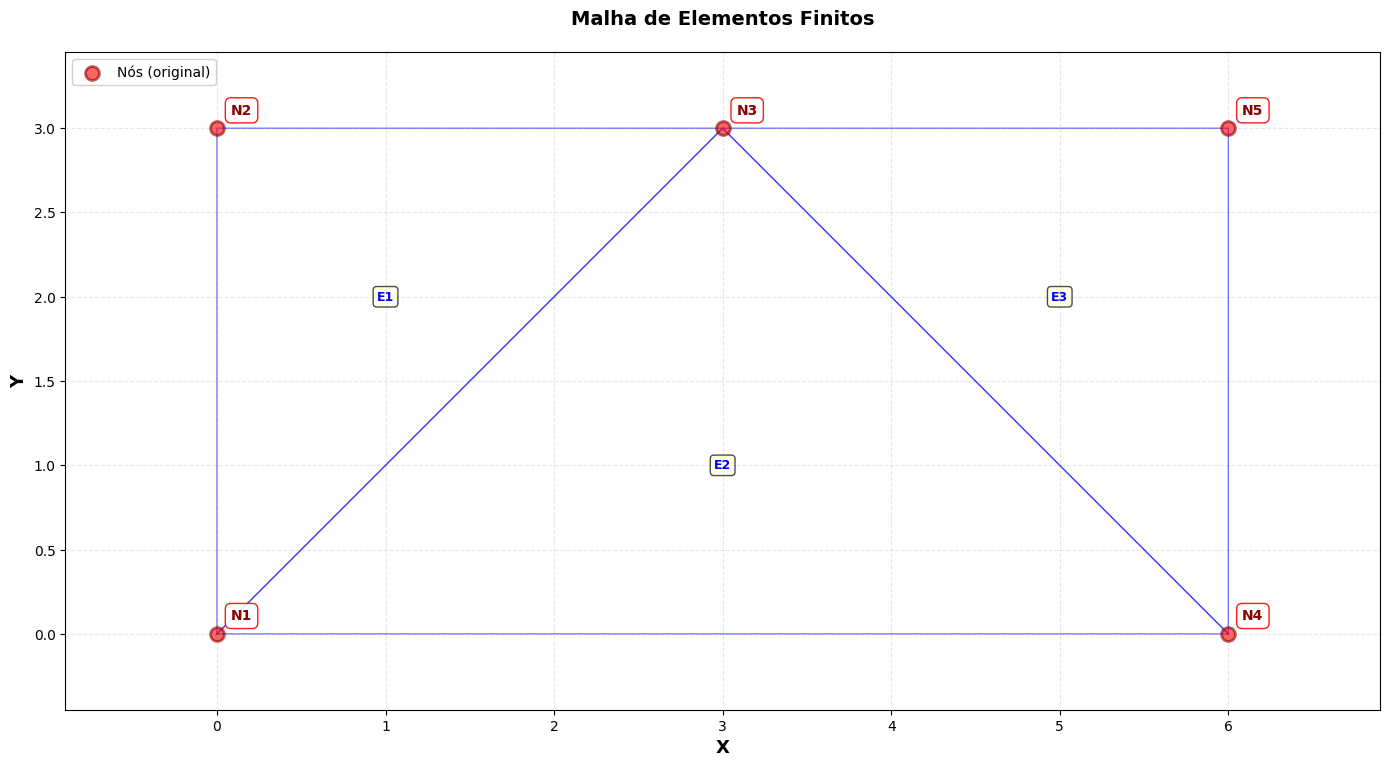

Matriz Csigma: 
 [[219.7802  65.9341   0.    ]
 [ 65.9341 219.7802   0.    ]
 [  0.       0.      76.9231]]
Matriz Global: 
 [[   1.        0.        0.        0.        0.        0.        0.        0.        0.        0.    ]
 [   0.        1.        0.        0.        0.        0.        0.        0.        0.        0.    ]
 [   0.        0.        1.        0.        0.        0.        0.        0.        0.        0.    ]
 [   0.        0.        0.        1.        0.        0.        0.        0.        0.        0.    ]
 [   0.        0.      -38.4615   71.4286  112.6374  -35.7143  -38.4615  -38.4615  -35.7143    2.7473]
 [   0.        0.       71.4286 -109.8901  -35.7143  184.0659  -32.967  -109.8901   -2.7473   35.7143]
 [   0.        0.     -109.8901  -38.4615  -38.4615  -32.967   148.3516   71.4286    0.        0.    ]
 [   0.        0.      -32.967   -38.4615  -38.4615 -109.8901   71.4286  148.3516    0.        0.    ]
 [ -38.4615   38.4615  -38.4615  -71.4286  -35.7143

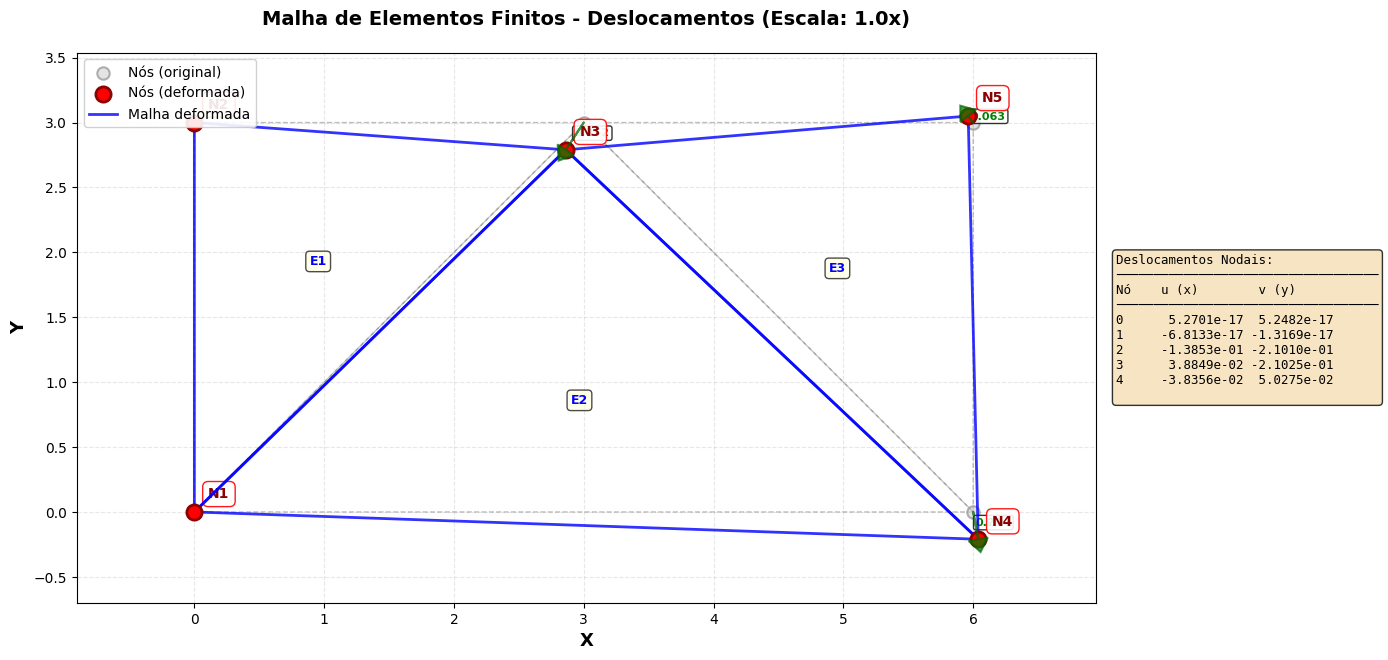

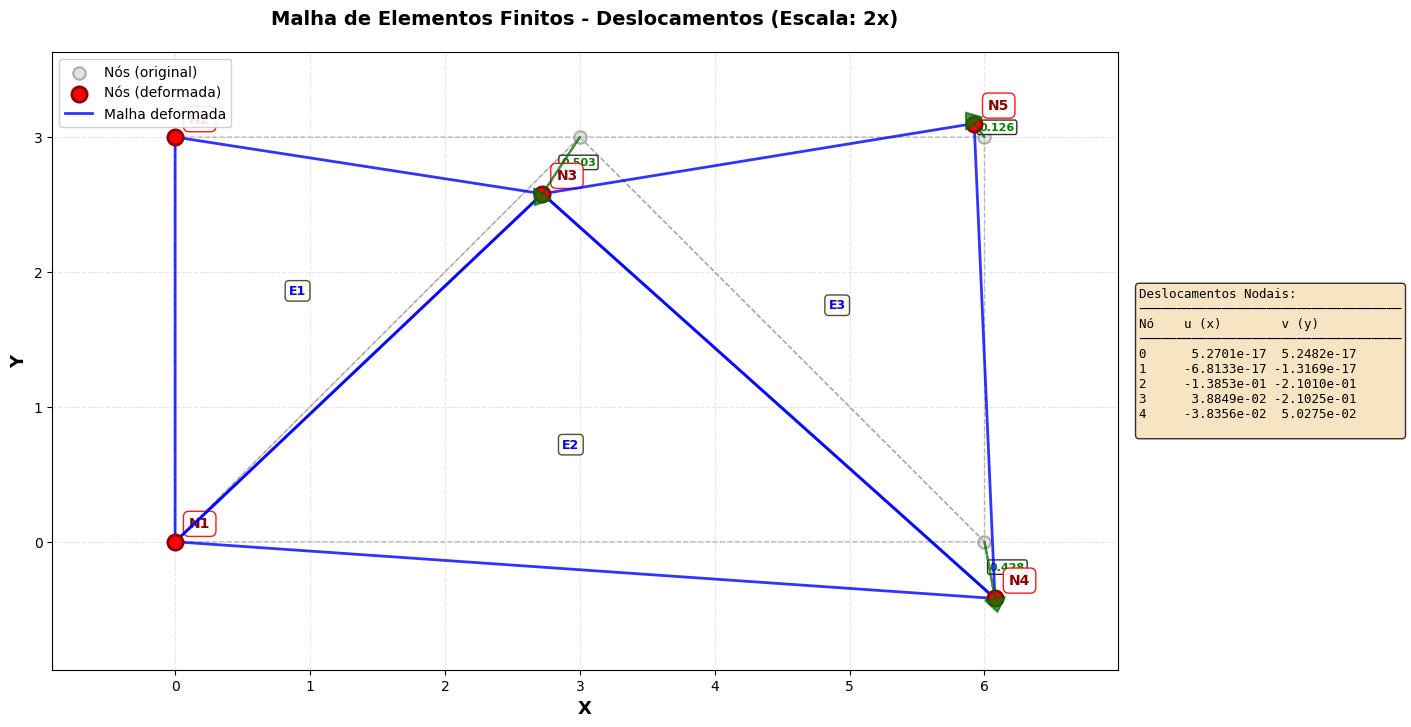

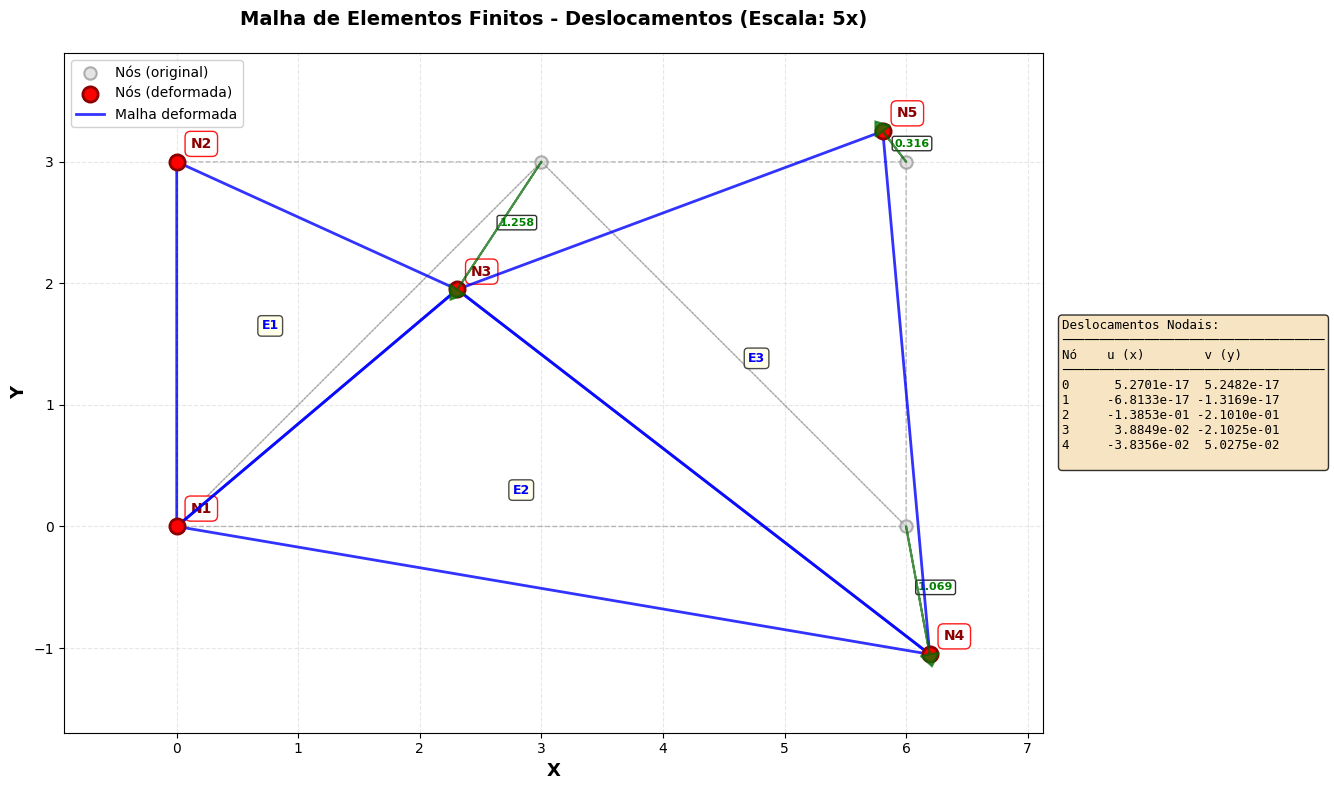

In [915]:

num_Elementos = 3
Le=3.0

index_nos = np.array([[0,2,1],[0,3,2],[3,4,2]])

pos_nos = np.array([
    [Le*0,0],[Le*0,h],[Le*1,h],[Le*2,0],[Le*2,h]
 ])
F_pos = [
    {"glib":5,"forca":-F},
    {"glib":6,"forca":q},
    {"glib":8,"forca":q},
]

plot_malha_com_deslocamento(pos_nos, index_nos)
Finitos = ElementosFinitos(Tipo_Estado="EPT", Mod_Elasticidade=E, poisson=poisson,Num_elementos=3,Num_nos=5)

CC_Glib = np.array([0,1,2,3], dtype=int)
CC_val = np.array([0.0, 0.0, 0.0,0.0])

displace, stress, strain = Finitos.CalculaDisp(F_pos,pos_nos,index_nos,CC_Glib,CC_val)
Finitos.show_res(show_steps=True)


print("Plot Deslocamento nodal:")
plot_malha_com_deslocamento(pos_nos, index_nos, displace)
plot_malha_com_deslocamento(pos_nos, index_nos, displace,fator_escala=2)
plot_malha_com_deslocamento(pos_nos, index_nos, displace,fator_escala=5)




## Malha 2

4 Elementos finitos triangulares

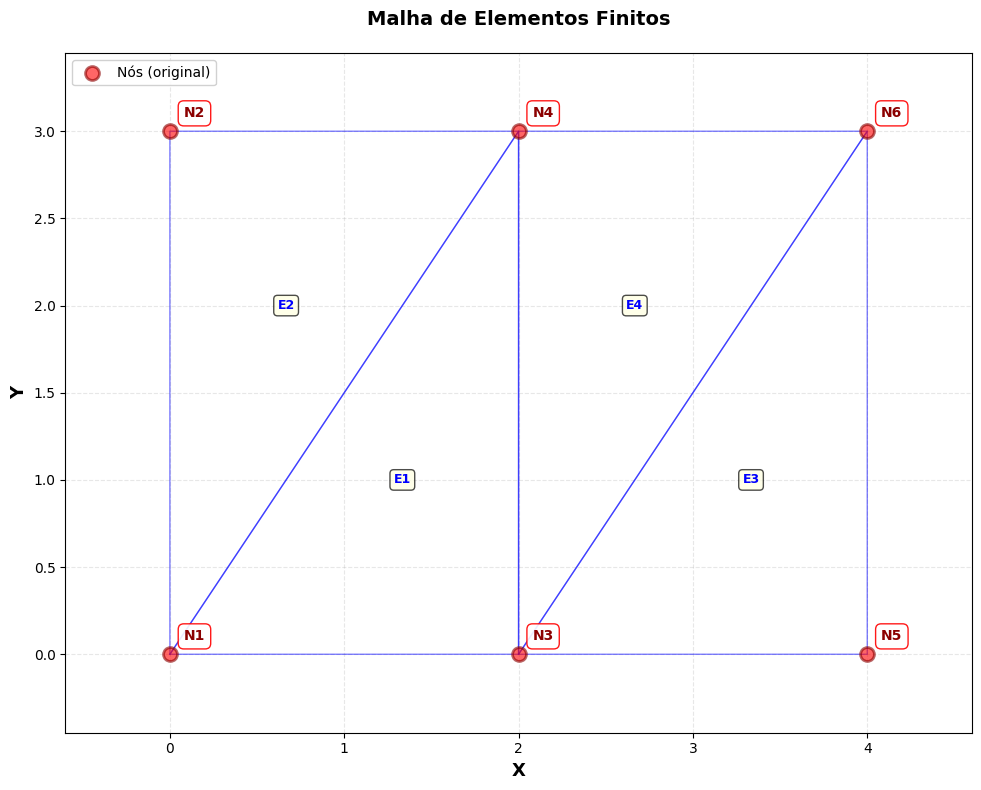

Matriz Csigma: 
 [[219.7802  65.9341   0.    ]
 [ 65.9341 219.7802   0.    ]
 [  0.       0.      76.9231]]
Matriz Global: 
 [[   1.        0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        0.    ]
 [   0.        1.        0.        0.        0.        0.        0.        0.        0.        0.        0.        0.    ]
 [   0.        0.        1.        0.        0.        0.        0.        0.        0.        0.        0.        0.    ]
 [   0.        0.        0.        1.        0.        0.        0.        0.        0.        0.        0.        0.    ]
 [-164.8352   32.967   -51.2821   71.4286  380.9524  -71.4286    0.        0.     -164.8352   38.4615    0.      -71.4286]
 [  38.4615  -57.6923   71.4286 -146.5201  -71.4286  261.9048    0.        0.       32.967   -57.6923  -71.4286    0.    ]
 [   0.        0.     -164.8352   38.4615    0.        0.      190.4762  -71.4286  -25.641    32.967     0.        0.    ]
 [   0.       

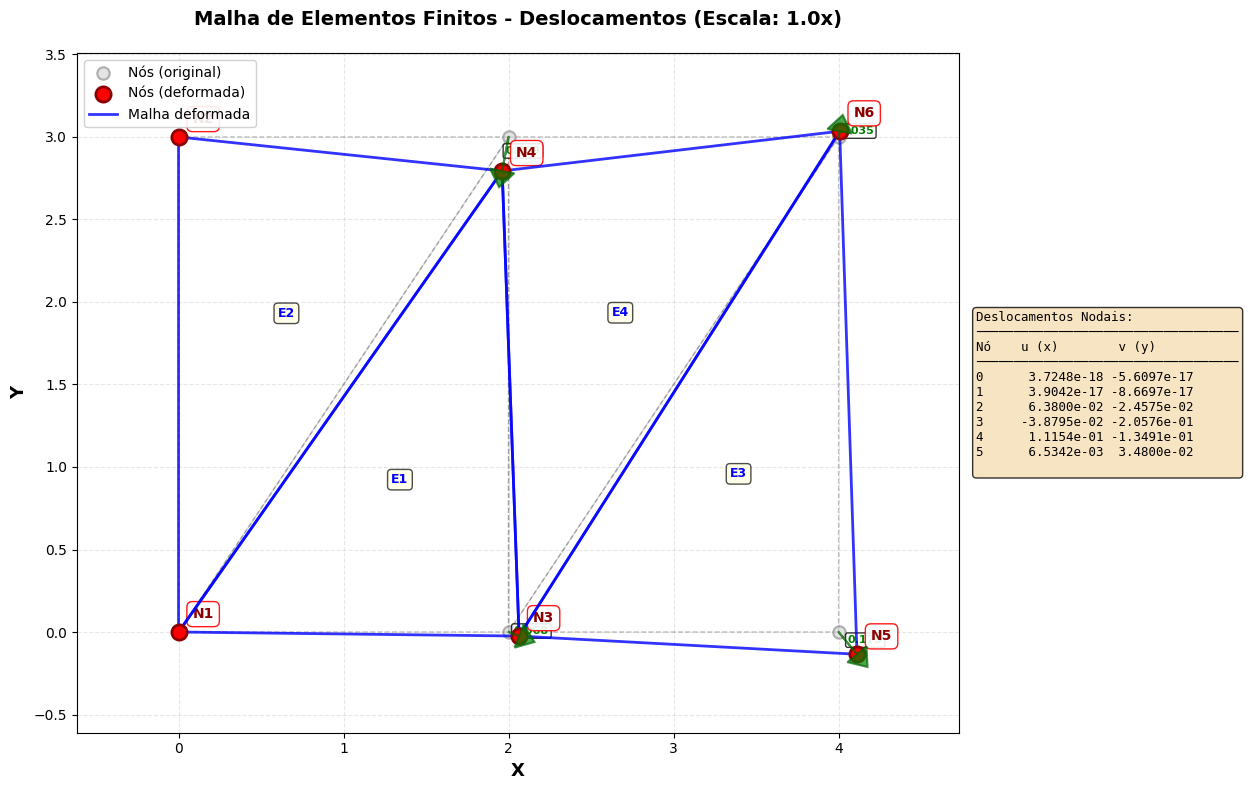

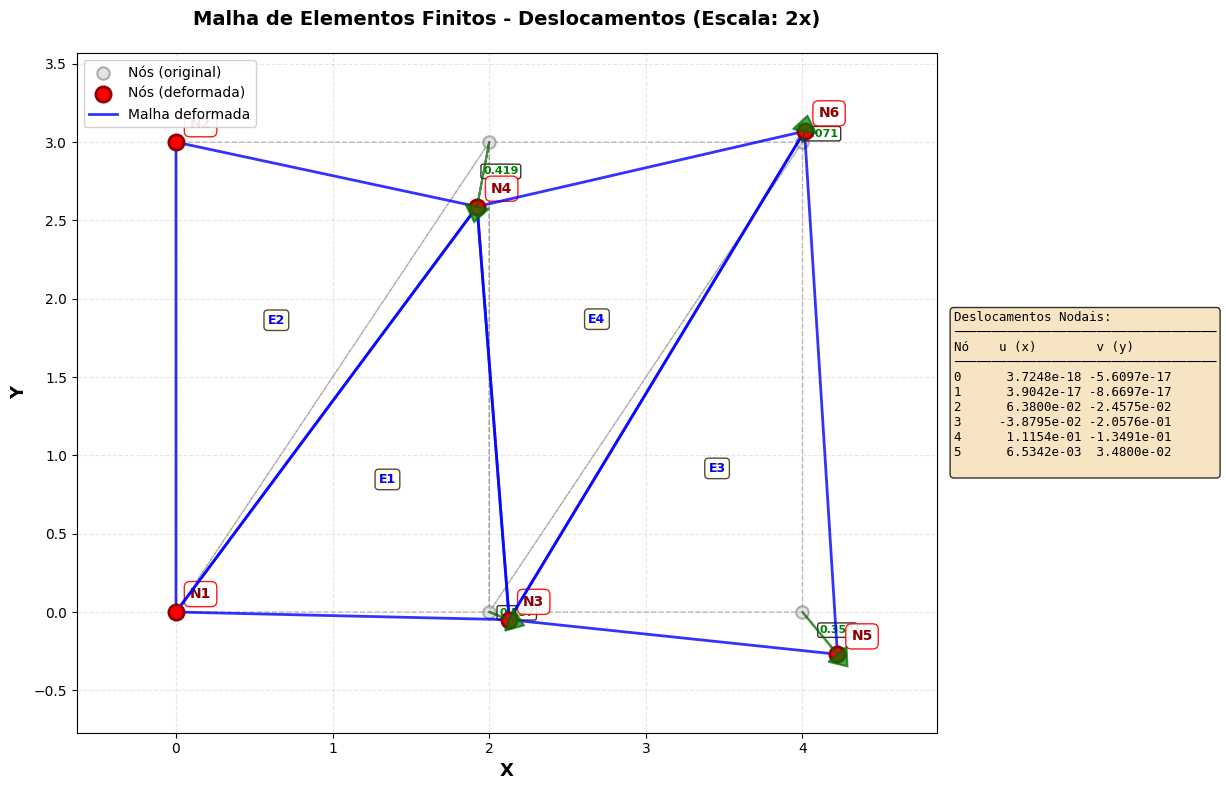

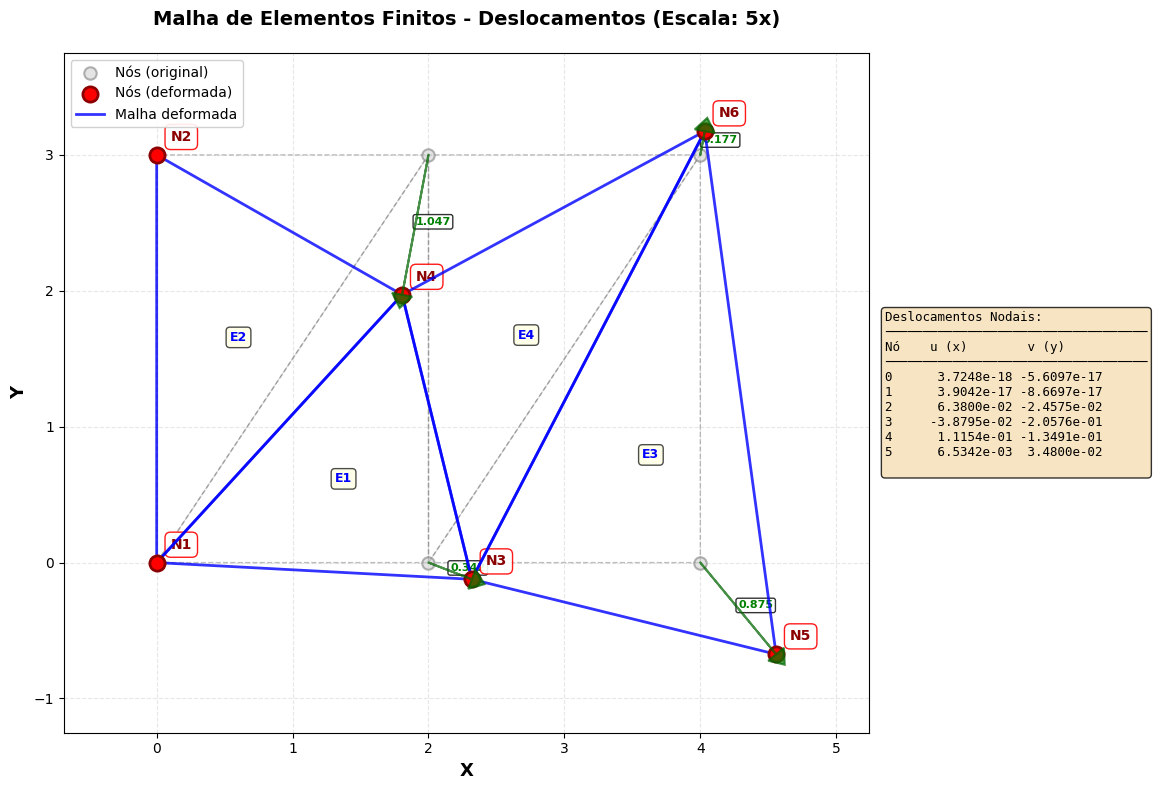

In [916]:
num_Elementos = 4
Le = 2.0
index_nos = np.array([[0,2,3],[0,3,1],[2,4,5],[2,5,3]])

pos_nos = np.array([
    [Le*0,0],[Le*0,h],[Le*1,0],[Le*1,h],[Le*2,0],[Le*2,h]
])
            
plot_malha_com_deslocamento(pos_nos, index_nos)
Finitos = ElementosFinitos(Tipo_Estado="EPT", Mod_Elasticidade=E, poisson=poisson,Num_elementos=4,Num_nos=6)

F_pos = [
    {"glib":7,"forca":-F},
    {"glib":8,"forca":q},
    {"glib":10,"forca":q},
]
CC_Glib = np.array([0,1,2,3], dtype=int)
CC_val = np.array([0.0, 0.0, 0.0,0.0])

displace, stress, strain = Finitos.CalculaDisp(F_pos,pos_nos,index_nos,CC_Glib,CC_val)

Finitos.show_res(show_steps=True)

print("Plot Deslocamento nodal:")
plot_malha_com_deslocamento(pos_nos, index_nos, displace)
plot_malha_com_deslocamento(pos_nos, index_nos, displace,fator_escala=2)
plot_malha_com_deslocamento(pos_nos, index_nos, displace,fator_escala=5)

## Malha 3

8 Elementos finitos triangulares

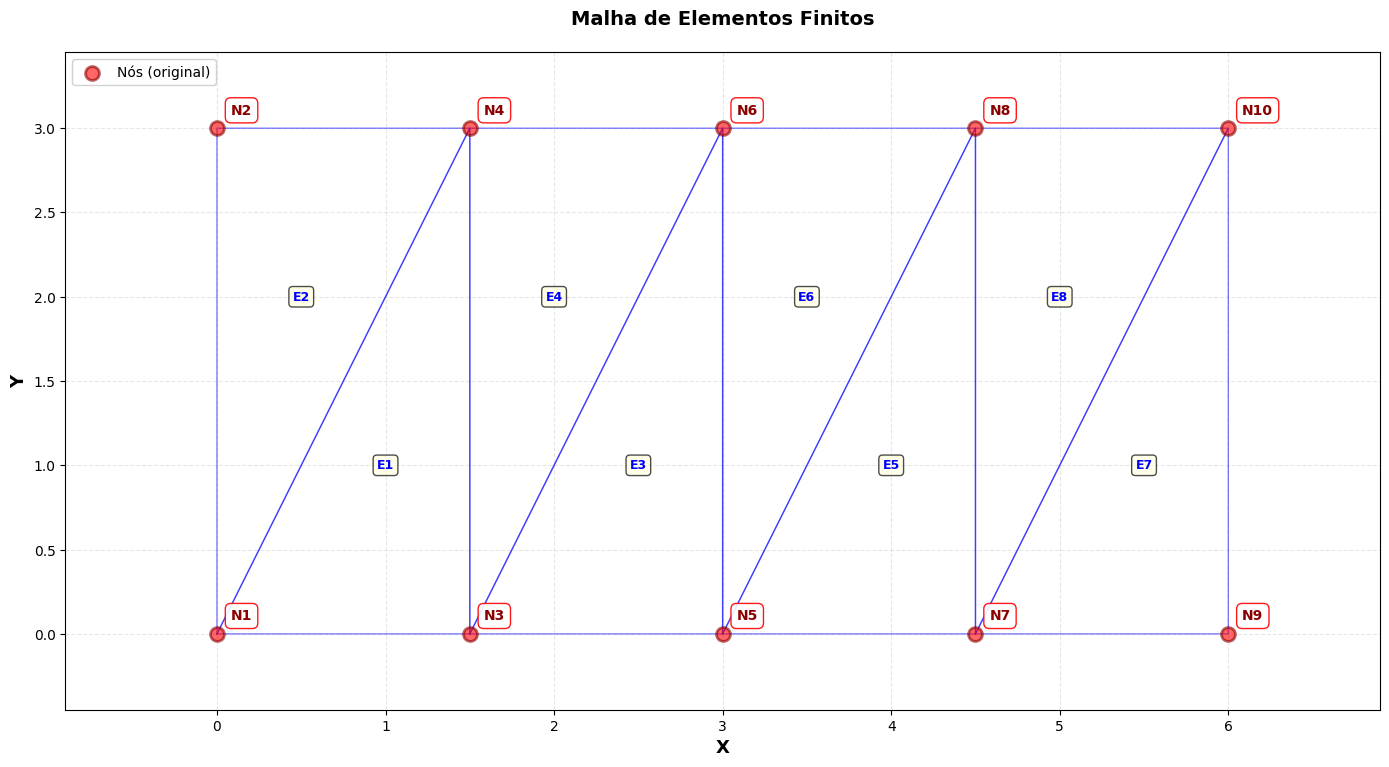

Matriz Csigma: 
 [[219.7802  65.9341   0.    ]
 [ 65.9341 219.7802   0.    ]
 [  0.       0.      76.9231]]
Matriz Global: 
 [[   1.        0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        0.
     0.    ]
 [   0.        1.        0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        0.
     0.    ]
 [   0.        0.        1.        0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        0.
     0.    ]
 [   0.        0.        0.        1.        0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        0.        0.
     0.    ]
 [-219.7802   32.967   -38.4615   71.4286  478.022   -71.4286    0.    

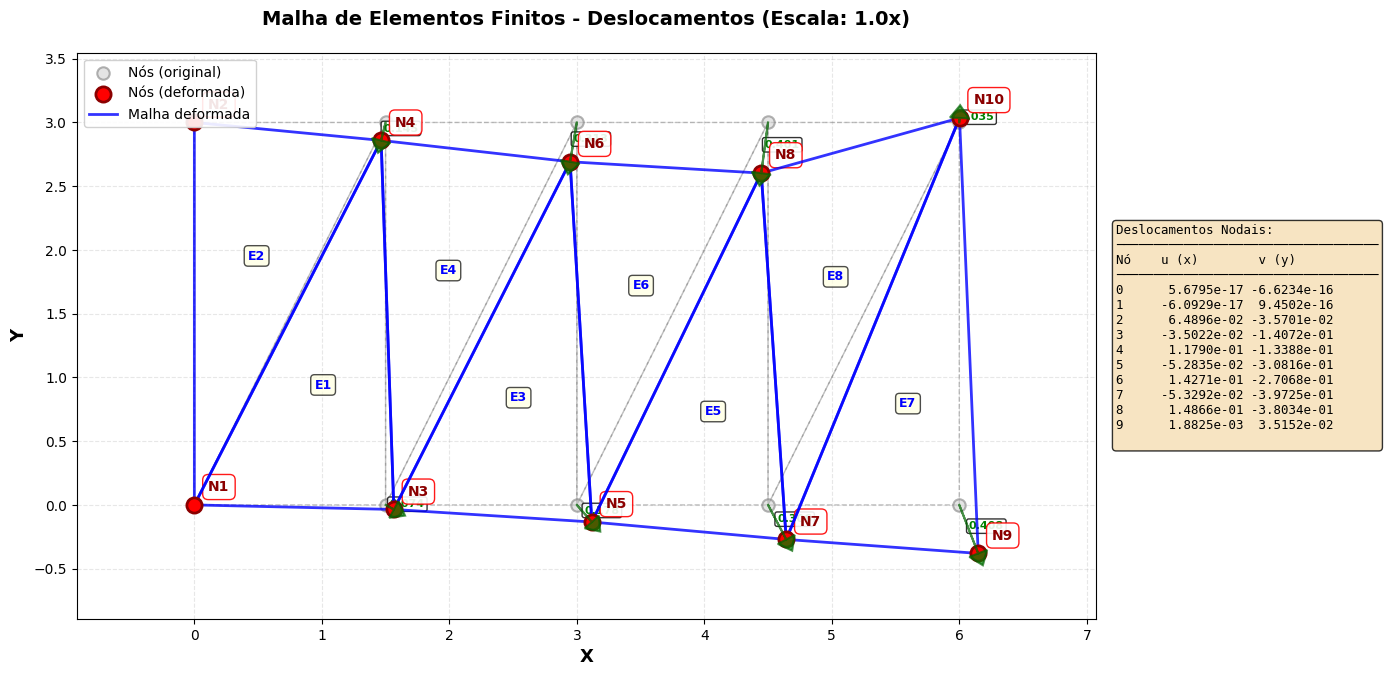

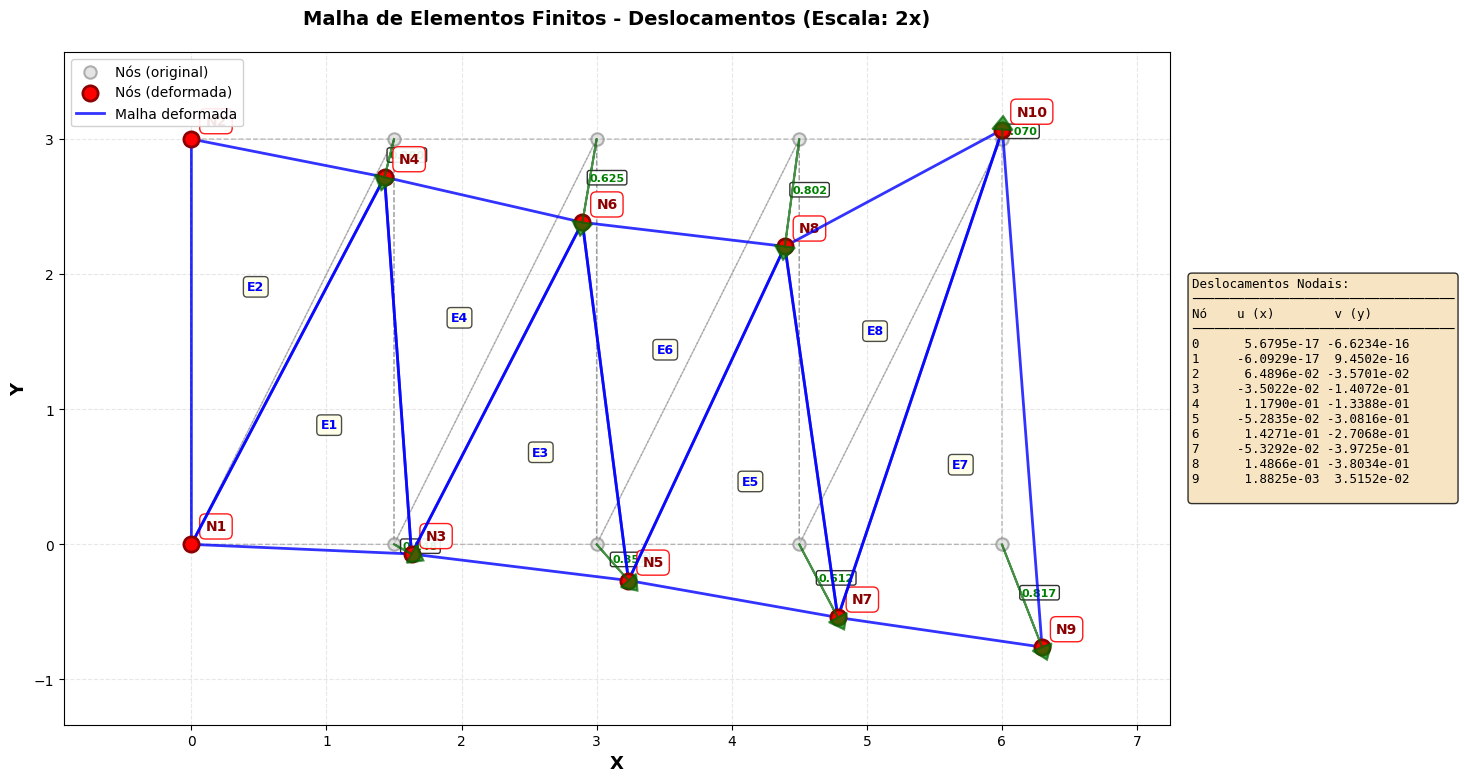

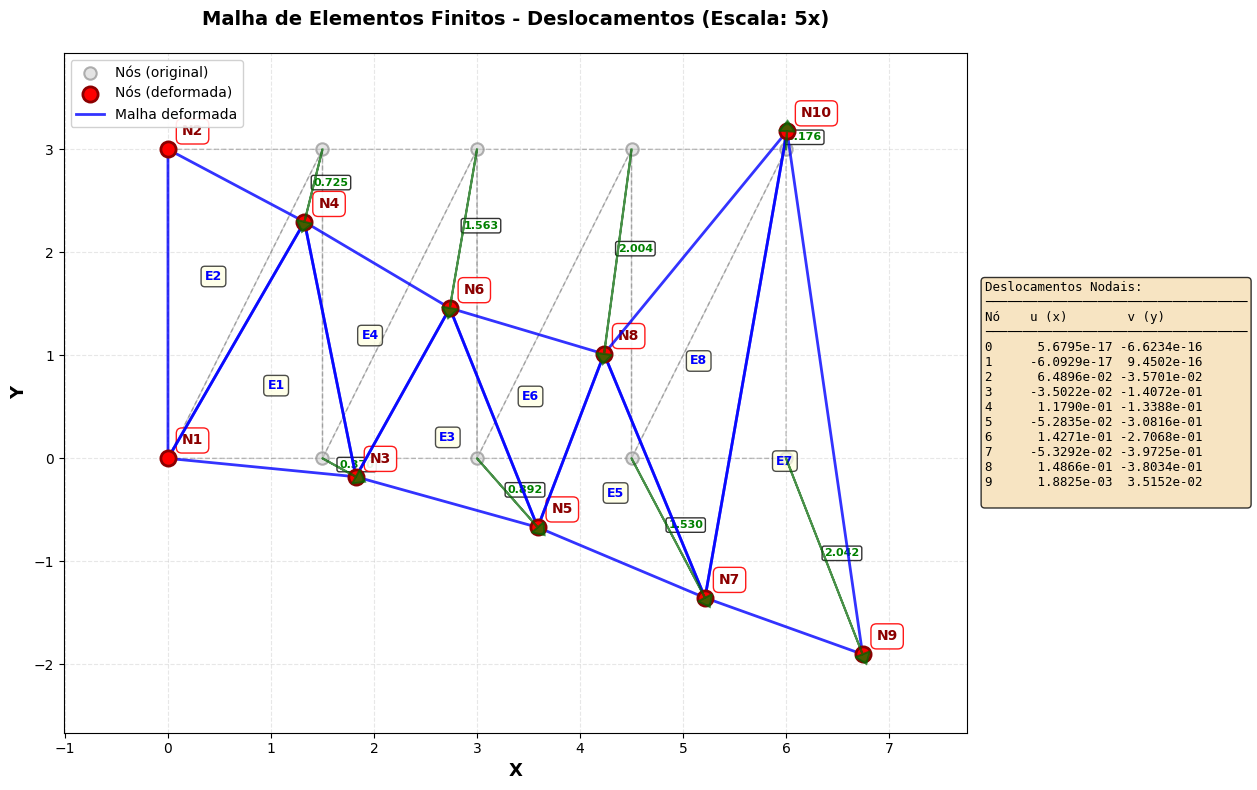

In [917]:
num_Elementos = 8
Le = 1.5
index_nos = np.array([[0,2,3],[0,3,1],[2,4,5],[2,5,3],[4,6,7],[4,7,5],[6,8,9],[6,9,7]])

pos_nos = np.array([
    [0,0],[0,h],[Le,0],[Le,h],[Le*2,0],[Le*2,h],[Le*3,0],[Le*3,h],[Le*4,0],[Le*4,h]
])
            
plot_malha_com_deslocamento(pos_nos, index_nos)
Finitos = ElementosFinitos(Tipo_Estado="EPT", Mod_Elasticidade=E, poisson=poisson,Num_elementos=8,Num_nos=10)

F_pos = [
    {"glib":11,"forca":-F},
    {"glib":16,"forca":q},
    {"glib":18,"forca":q},
]
CC_Glib = np.array([0,1,2,3], dtype=int)
CC_val = np.array([0.0, 0.0, 0.0,0.0])

displace, stress, strain = Finitos.CalculaDisp(F_pos,pos_nos,index_nos,CC_Glib,CC_val)
Finitos.show_res(show_steps=True)

print("Plot Deslocamento nodal:")
plot_malha_com_deslocamento(pos_nos, index_nos, displace)
plot_malha_com_deslocamento(pos_nos, index_nos, displace,fator_escala=2)
plot_malha_com_deslocamento(pos_nos, index_nos, displace,fator_escala=5)